In [1]:
import sys
import re
import os
from datetime import datetime
from time import sleep
from IPython.display import display, clear_output, HTML

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import utils
from utils import *
import torch
import pandas as pd
import numpy as np
import torch
from glob import glob
import selenium
from tqdm.auto import tqdm

START_TS = datetime.now()
display(HTML(f'{START_TS} - Current working directory: <b>{WORKING_DIR}</b>'))

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import numba



2021-06-05 22:18:15,163 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-05 22:18:15,165 -INFO - common:common.py:616 - Module utils.common is loaded...
2021-06-05 22:18:15,166 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-05 22:18:15,168 -INFO - dataset_builder:dataset_builder.py:202 - dataset package is loaded...
2021-06-05 22:18:15,840 -INFO - dataset:dataset.py:653 - dataset module is loaded...


In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

In [3]:
selenium.__version__

'3.141.0'

# Parameters

In [4]:
SITE_URL = 'https://jdi-testing.github.io/jdi-light/'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

In [5]:
with open('dataset/classes.txt', 'r') as f:
    decoder_dict = { i:s.strip() for i, s in  enumerate(f.readlines())}
    encoder_dict = { v: k for k, v in decoder_dict.items()}
decoder_dict, encoder_dict

({0: 'button',
  1: 'link',
  2: 'textfield',
  3: 'dropdown',
  4: 'checkbox',
  5: 'radiobutton',
  6: 'textarea',
  7: 'fileinput',
  8: 'iframe',
  9: 'range',
  10: 'progressbar',
  11: 'datetimeselector',
  12: 'colorpicker',
  13: 'numberselector',
  14: 'selector',
  15: 'table',
  16: 'slider-toggle',
  17: 'slider',
  18: 'tree-node',
  19: 'steper',
  20: 'tab',
  21: 'n/a'},
 {'button': 0,
  'link': 1,
  'textfield': 2,
  'dropdown': 3,
  'checkbox': 4,
  'radiobutton': 5,
  'textarea': 6,
  'fileinput': 7,
  'iframe': 8,
  'range': 9,
  'progressbar': 10,
  'datetimeselector': 11,
  'colorpicker': 12,
  'numberselector': 13,
  'selector': 14,
  'table': 15,
  'slider-toggle': 16,
  'slider': 17,
  'tree-node': 18,
  'steper': 19,
  'tab': 20,
  'n/a': 21})

# Generate dataset

2021-06-05 22:18:15,957 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: html-5
2021-06-05 22:18:15,957 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-05 22:18:15,957 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-05 22:18:16,982 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-05 22:18:16,982 -INFO - <ipython-input-6-6f5299219e6c>:<ipython-input-6-6f5299219e6c>:5 - getting page
2021-06-05 22:18:34,844 -INFO - common:common.py:75 - Window maximized
2021-06-05 22:18:41,857 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/html-5.png
2021-06-05 22:18:42,213 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-05 22:18:42,695 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/html-5.html
2021-06-05 22:18:42,716 -INFO - dataset_builder:dataset_builder.py:196 - Save parquet to da

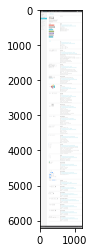

In [6]:
DATASET_NAME = 'html-5'
class JDIDatasetBuilder(DatasetBuilder):

    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_URL)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("HTML 5").click()
        sleep(WAIT_TIME_SECONDS)
        
#         driver.find_element_by_link_text("Service").click()
#         driver.find_element_by_link_text("Complex Table").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)
        

with JDIDatasetBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))



In [7]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')

In [8]:
df = build_features(df)

2021-06-05 22:18:43,542 -INFO - hidden:hidden.py:107 - build field "is_hidden"


In [9]:
elements_dict = build_elements_dict(df)

In [10]:
df[['tag_name', 'element_id', 'parent_id', 'upper_sibling', 'lower_sibling', 'displayed', 'is_hidden', 'x', 'y', 'width', 'height']]

,tag_name,element_id,parent_id,upper_sibling,lower_sibling,displayed,is_hidden,x,y,width,height
0,HTML,8063769639207222231745650998,None,None,None,True,0,0.0,0.0,1183.0,6191.0
1,HEAD,4311382232207222239444261431,8063769639207222231745650998,None,0390910725207222237575252585,False,0,0.0,0.0,0.0,0.0
2,META,9617754713207222236410451698,4311382232207222239444261431,None,7636112651207222234671478350,False,0,0.0,0.0,0.0,0.0
3,TITLE,7636112651207222234671478350,4311382232207222239444261431,9617754713207222236410451698,2712149552207222233691306619,False,0,0.0,0.0,0.0,0.0
4,META,2712149552207222233691306619,4311382232207222239444261431,7636112651207222234671478350,0940949930207222236440052849,False,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
660,SCRIPT,9275643875207222249426090093,0390910725207222237575252585,5077777893207222243992158584,8108668120207222246724334447,False,1,0.0,0.0,0.0,0.0
661,SCRIPT,8108668120207222246724334447,0390910725207222237575252585,9275643875207222249426090093,3690645982207222243404563243,False,1,0.0,0.0,0.0,0.0
662,SCRIPT,3690645982207222243404563243,0390910725207222237575252585,8108668120207222246724334447,1725821669207222247889722227,False,1,0.0,0.0,0.0,0.0
663,SCRIPT,1725821669207222247889722227,0390910725207222237575252585,3690645982207222243404563243,6926484501207222248193323207,False,1,0.0,0.0,0.0,0.0


In [11]:
predictions_df = rule_base_predict(df)
print(predictions_df.shape)
# predictions_df

2021-06-05 22:18:44,064 -INFO - common:common.py:489 - Num radio buttons found: 4
2021-06-05 22:18:44,067 -INFO - common:common.py:493 - Num radio2 buttons found: 0
2021-06-05 22:18:44,070 -INFO - common:common.py:500 - Num checkboxes found: 5
2021-06-05 22:18:44,074 -INFO - common:common.py:507 - Num comboboxes/dropdowns found: 0
2021-06-05 22:18:44,076 -INFO - common:common.py:518 - Num textfields found: 8
2021-06-05 22:18:44,079 -INFO - common:common.py:523 - Num texfields for numbers found: 1
2021-06-05 22:18:44,082 -INFO - common:common.py:528 - Num ranges found: 5
2021-06-05 22:18:44,084 -INFO - common:common.py:533 - Num ordinary text inputs found: 0
2021-06-05 22:18:44,085 -INFO - common:common.py:536 - Num buttons found: 9
2021-06-05 22:18:44,087 -INFO - common:common.py:541 - Num buttons1 found: 1
2021-06-05 22:18:44,090 -INFO - common:common.py:546 - Num buttons2 (Material-UI) found: 0
2021-06-05 22:18:44,092 -INFO - common:common.py:551 - Num links found: 90
(26, 8)


# **Enrich predictions**

In [12]:
radio_df = df[(df.tag_name == 'MAT-RADIO-BUTTON') &
              df.displayed & (df.is_hidden == 0) & (df.width > 0.0) & (df.height>0.0)
             ].copy()
radio_df['label'] = encoder_dict['radiobutton']
radio_df = radio_df[predictions_df.columns]
radio_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [13]:
checkbox_df = df[(df.tag_name == 'MAT-CHECKBOX') &
              df.displayed & (df.is_hidden == 0) 
             ].copy()
checkbox_df['label'] = encoder_dict['checkbox']
checkbox_df = checkbox_df[predictions_df.columns]
checkbox_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [14]:
slider_toggle_df = df[(df.tag_name == 'MAT-SLIDE-TOGGLE') & df.displayed & (df.is_hidden == 0) 
             ].copy()
slider_toggle_df['label'] = encoder_dict['slider-toggle']
slider_toggle_df = slider_toggle_df[predictions_df.columns]
slider_toggle_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [15]:
selector_df = df[df.tag_name.isin(['MAT-SELECT', 'SELECT']) & df.displayed & (df.is_hidden == 0)].copy()
selector_df['label'] = encoder_dict['selector']
selector_df = selector_df[predictions_df.columns]
selector_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [16]:
text_df = df[(df.tag_name == 'INPUT') &
             (df.attributes.apply(lambda x: 'mat-input-element' in str(x.get('class')))) &
             df.displayed & 
             (df.is_hidden == 0)].copy()
text_df['label'] = encoder_dict['textfield']
text_df = text_df[predictions_df.columns]
text_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [17]:
textarea_df = df[(df.tag_name == 'TEXTAREA') &
             df.displayed & 
             (df.is_hidden == 0)].copy()
textarea_df['label'] = encoder_dict['textarea']
textarea_df = textarea_df[predictions_df.columns]
textarea_df

,element_id,x,y,width,height,displayed,is_hidden,label


In [18]:
tree_df = df[(df.tag_name == 'MAT-TREE-NODE') &
             df.displayed & 
             (df.is_hidden == 0)].copy()
tree_df['label'] = encoder_dict['tree-node']
tree_df = tree_df[predictions_df.columns]
tree_df

,element_id,x,y,width,height,displayed,is_hidden,label


# Put everything together

In [19]:
print(predictions_df.shape, radio_df.shape, checkbox_df.shape, selector_df.shape, text_df.shape, textarea_df.shape, tree_df.shape)
predictions_df = pd.concat([predictions_df, radio_df, checkbox_df, slider_toggle_df, selector_df, text_df, textarea_df, tree_df])

(26, 8) (0, 8) (0, 8) (0, 8) (0, 8) (0, 8) (0, 8)


1200 6208


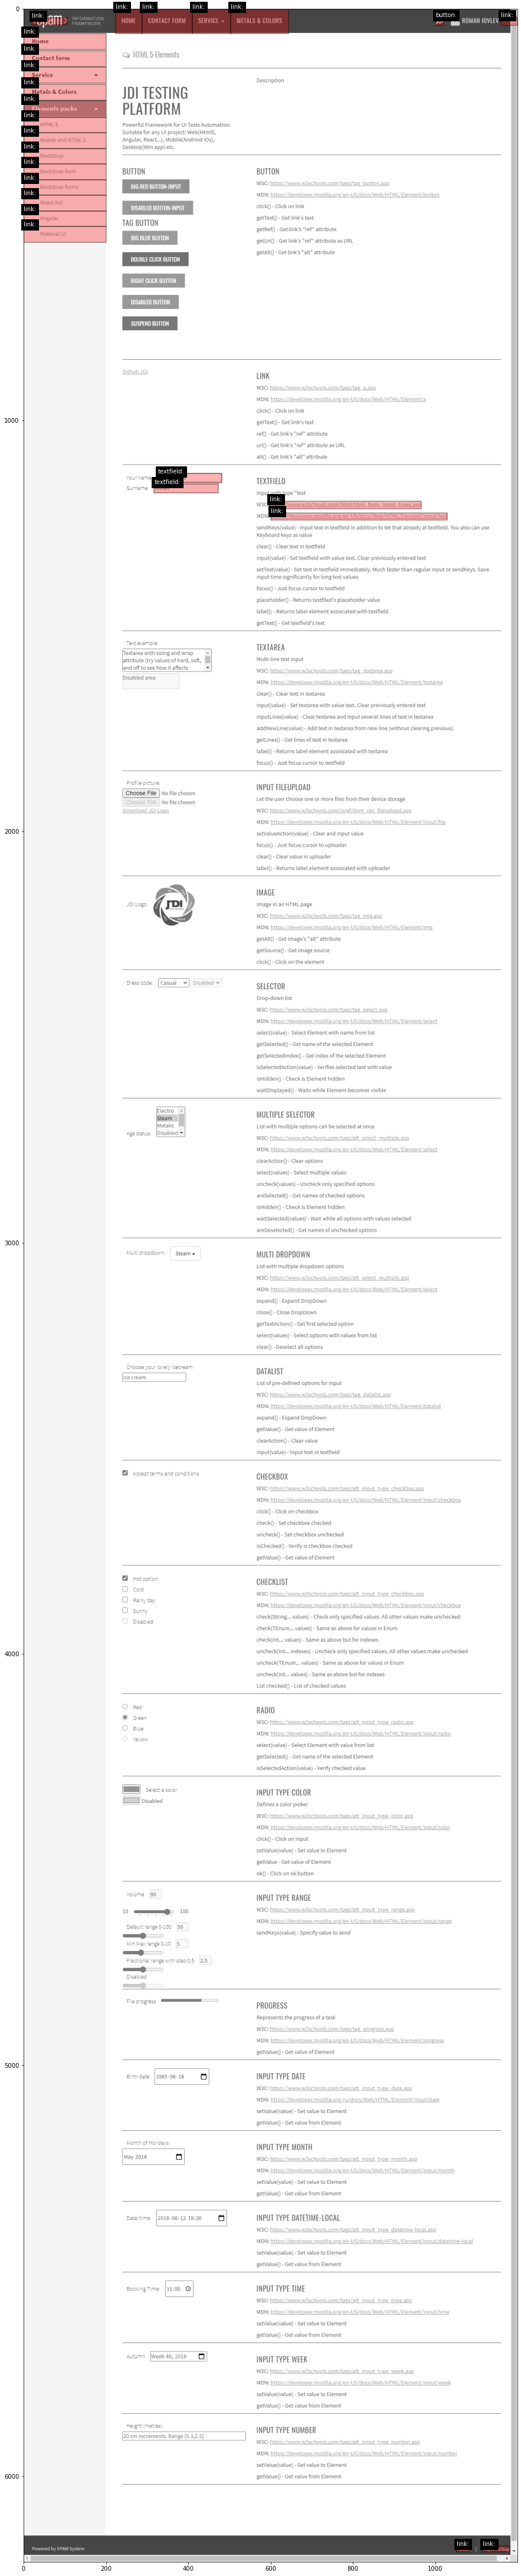

In [20]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 500))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for _, r in predictions_df.iterrows():
    
    patch = patches.Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    axes.add_patch(patch)
    plt.text(r.x, r.y, 
             decoder_dict[r.label] + ':',  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
    

# Generate and Save Labels

In [21]:
# labels = build_to_yolo(df = predictions_df, img_width=img_width, img_heght=img_height)
# labels

In [22]:
# labeled_df = pd.DataFrame(labels, columns=['label', 'x', 'y', 'width', 'height'])
# labeled_df.label = labeled_df.label.astype(int)
# display(labeled_df)
# labeled_df.to_csv(f'dataset/annotations/{DATASET_NAME}.txt', header=False, sep=' ', index=False)

# Preview Labels

In [39]:
boxes_df = pd.read_csv(f'dataset/annotations/{DATASET_NAME}.txt', sep=' ', names = ['label', 'x', 'y', 'width', 'height'])
boxes_df
boxes_df['box'] = boxes_df.apply(lambda r: from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height), axis=1)
boxes_df.head()

,label,x,y,width,height,box
0,1,0.052083,0.004591,0.070833,0.004349,"(19, 15, 84, 26)"
1,1,0.131250,0.004591,0.067500,0.004027,"(117, 16, 81, 24)"
2,1,0.211667,0.004832,0.050000,0.009343,"(224, 0, 60, 58)"
3,1,0.287083,0.004913,0.104167,0.009504,"(281, 0, 125, 59)"
4,1,0.377917,0.004913,0.075833,0.009504,"(408, 0, 90, 59)"


In [40]:
# img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
# img_height, img_width = img.shape
# print(img_width, img_height)
# plt.figure(figsize=(15, 500))
# plt.imshow(img, cmap='gray')
# axes = plt.gca()

# for i, r in boxes_df.iterrows():
#     x, y, w, h = from_yolo(r.x, r.y, r.width, r.height, img_width=img_width, img_height=img_height)    
#     patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
#     axes.add_patch(patch)
#     plt.text(x, y, 
#              f'({i})' + decoder_dict[r.label] + ':',  ## + r.element_id, 
#              fontsize = 10, 
#              color = 'white', 
#              backgroundcolor='black',
#              alpha=1.)
    

In [41]:
# df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx_x',
       'idx_y', 'label', 'annotation_line_no', 'iou', 'tag', 'label_text'],
      dtype='object')

In [42]:
columns_to_drop = set(df.columns).intersection(set(['label', 'annotation_line_no', 'iou', 'tag', 'label_text']))
if len(columns_to_drop) >= 0:
    df.drop(columns=columns_to_drop, inplace=True)

In [43]:
df = assign_labels(df=df, annotations_file_path=f'dataset/annotations/{DATASET_NAME}.txt', img_width=img_width, img_height=img_height)

2021-06-05 22:31:38,511 -INFO - labels:labels.py:38 - Assign labels from annotation file: dataset/annotations/html-5.txt
2021-06-05 22:31:38,512 -INFO - labels:labels.py:40 - Getting image size
2021-06-05 22:31:38,512 -INFO - labels:labels.py:42 - Image size (w,h): (1200, 6208)
2021-06-05 22:31:38,513 -INFO - labels:labels.py:47 - {'button': 0, 'link': 1, 'textfield': 2, 'dropdown': 3, 'checkbox': 4, 'radiobutton': 5, 'textarea': 6, 'fileinput': 7, 'iframe': 8, 'range': 9, 'progressbar': 10, 'datetimeselector': 11, 'colorpicker': 12, 'numberselector': 13, 'selector': 14, 'table': 15, 'slider-toggle': 16, 'slider': 17, 'tree-node': 18, 'steper': 19, 'tab': 20, 'n/a': 21}
2021-06-05 22:31:38,514 -INFO - labels:labels.py:55 - getting "n/a" class code
2021-06-05 22:31:38,514 -INFO - labels:labels.py:62 - "n/a" class code: 21
2021-06-05 22:31:38,516 -INFO - labels:labels.py:72 - 112 annotation has been read


Assign labels:   0%|          | 0/112 [00:00<?, ?it/s]

2021-06-05 22:31:45,626 -INFO - labels:labels.py:121 - labels_df: Index(['idx', 'label', 'annotation_line_no', 'iou', 'tag', 'label_text'], dtype='object')
2021-06-05 22:31:45,626 -INFO - labels:labels.py:124 - 112 labels have been assigned


In [44]:
df.columns

Index(['attributes', 'displayed', 'element_id', 'height', 'onmouseenter',
       'onmouseover', 'parent_id', 'style', 'tag_name', 'text', 'width', 'x',
       'y', 'is_hidden', 'upper_sibling', 'lower_sibling', 'siblings', 'idx_x',
       'idx_y', 'idx', 'label', 'annotation_line_no', 'iou', 'tag',
       'label_text'],
      dtype='object')

In [45]:
df.label.value_counts()

21    553
1      69
0       8
4       6
11      5
17      5
5       4
14      4
2       3
6       2
7       2
12      2
10      1
13      1
Name: label, dtype: int64

1200 6208


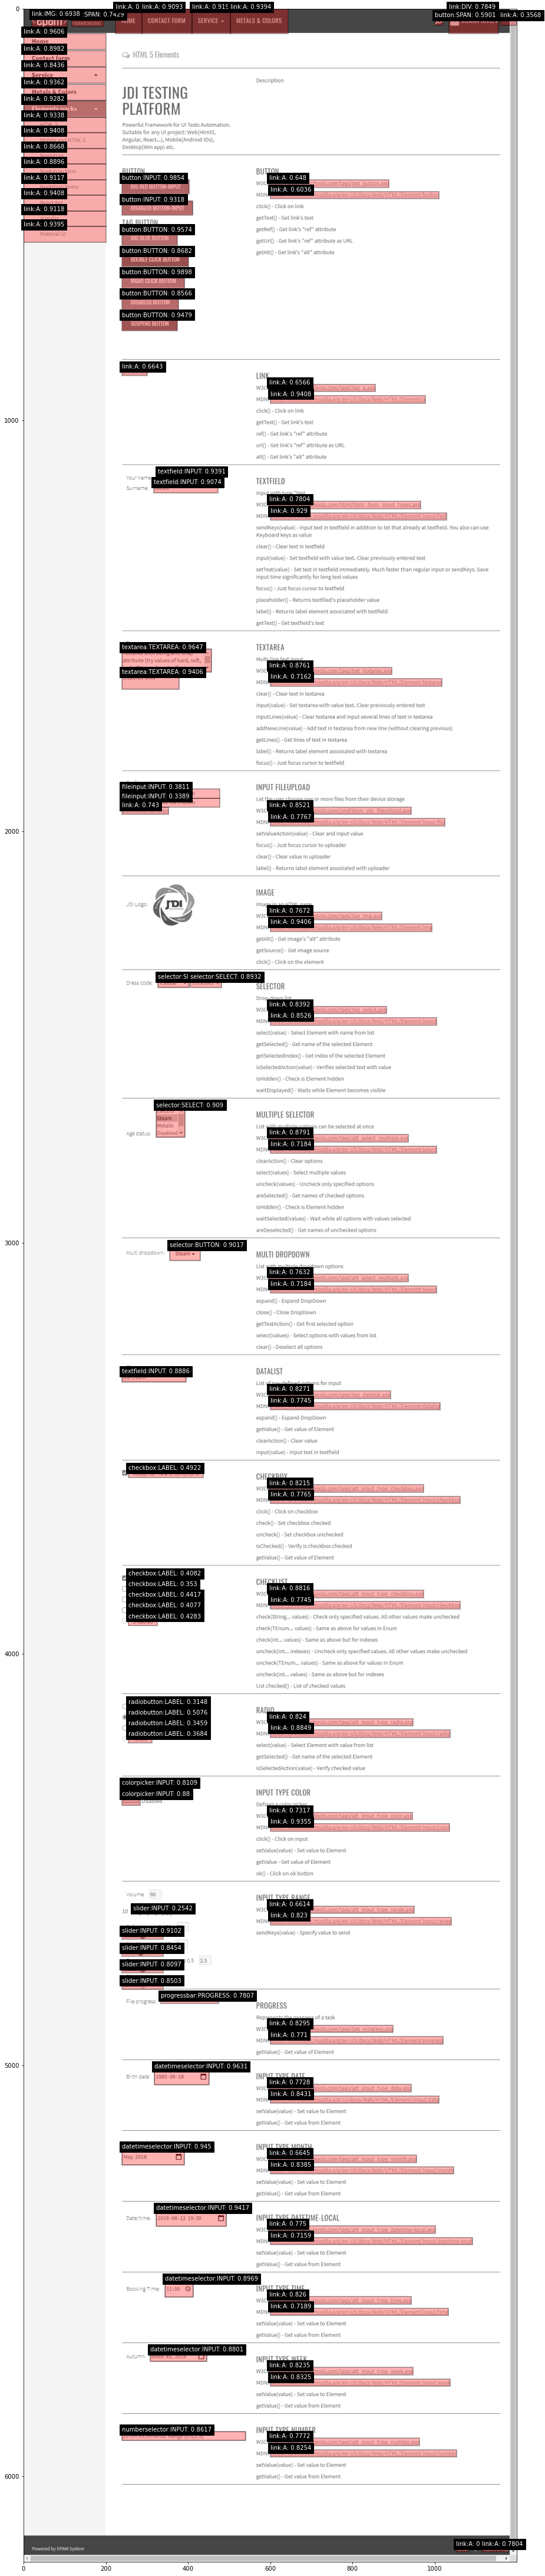

In [46]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
img_height, img_width = img.shape
print(img_width, img_height)
plt.figure(figsize=(15, 500))
plt.imshow(img, cmap='gray')
axes = plt.gca()

for _, r in df[df.label_text != 'n/a'].iterrows():
    x, y, w, h = r.x, r.y, r.width, r.height  
    patch = patches.Rectangle((x, y), w, h, linewidth=2, alpha = .3, facecolor = 'red', edgecolor ='black')
    
    # print(r.tag_name, r.label_text, (x,y,w,h), r.element_id)
    
    axes.add_patch(patch)
    plt.text(x, y, 
             decoder_dict[r.label] + ':' + r.tag_name + ': ' +str(round(r.iou, 4)), # + ':' + str((x, y, w, h)),  ## + r.element_id, 
             fontsize = 10, 
             color = 'white', 
             backgroundcolor='black',
             alpha=1.)
